# Exploring Global Continuous Bag of Words (CBOW) Optimization

---

Elliott Forney - 2020

In [1]:
%%bash
#pip3 install 'git+ssh://git@github.com/IBM/regenerator@0.2.0' --user

In [2]:
import copy
import collections, itertools
import math
import random, re

import regenerator
import munch
import nltk

import scipy as sp
import scipy.spatial.distance as spdist

import torch as th
import torch.nn.functional as thfunc

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [3]:
class Tokenizer:                                                                                    
    def __init__(self):
        #self.nltk_word_tokenizer = nltk.tokenize.WordPunctTokenizer()                              
        self.nltk_word_tokenizer = nltk.tokenize.TreebankWordTokenizer()                            
        self.nltk_sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
                                                                                                    
    def __call__(self, text):                                                                       
        return [self.nltk_word_tokenizer.tokenize(sent)                                             
                for sent in self.nltk_sent_tokenizer.tokenize(text)]

In [4]:
tokenizer = Tokenizer()

In [5]:
raw_stream = regenerator.Stream.from_txt('wikipedia.txt')

In [6]:
raw_stream

<Stream>:
'Anarchism\n',
"Anarchism is an anti-authoritarian political and social philosophy that rejects hierarchy as unjust and advocates its replacement with self-managed, self-governed societies based on voluntary, cooperative institutions. These institutions are often described as stateless societies, although several authors have defined them more specifically as distinct institutions based on non-hierarchical or free associations. Anarchism's central disagreement with other ideologies is that it holds the state to be undesirable, unnecessary, and harmful.\n",
'Anarchism is usually placed on the far-left of the political spectrum, and much of its economics and legal philosophy reflect anti-authoritarian interpretations of communism, collectivism, syndicalism, mutualism, or participatory economics. As anarchism does not offer a fixed body of doctrine from a single particular worldview, many anarchist types and traditions exist and varieties of anarchy diverge widely. Anarchist sch

In [7]:
token_stream = (
    raw_stream
    .map(str.lower)
    .map(str.strip)
    .map(tokenizer)
    .unchunk()
)

In [8]:
token_stream

<Stream>:
['anarchism'],
['anarchism', 'is', 'an', 'anti-authoritarian', 'political', 'and', 'social', 'philosophy', 'that', 'rejects', 'hierarchy', 'as', 'unjust', 'and', 'advocates', 'its', 'replacement', 'with', 'self-managed', ',', 'self-governed', 'societies', 'based', 'on', 'voluntary', ',', 'cooperative', 'institutions', '.'],
['these', 'institutions', 'are', 'often', 'described', 'as', 'stateless', 'societies', ',', 'although', 'several', 'authors', 'have', 'defined', 'them', 'more', 'specifically', 'as', 'distinct', 'institutions', 'based', 'on', 'non-hierarchical', 'or', 'free', 'associations', '.'],
['anarchism', "'s", 'central', 'disagreement', 'with', 'other', 'ideologies', 'is', 'that', 'it', 'holds', 'the', 'state', 'to', 'be', 'undesirable', ',', 'unnecessary', ',', 'and', 'harmful', '.'],
['anarchism', 'is', 'usually', 'placed', 'on', 'the', 'far-left', 'of', 'the', 'political', 'spectrum', ',', 'and', 'much', 'of', 'its', 'economics', 'and', 'legal', 'philosophy', 're

In [9]:
min_sent_len = 5
max_sent_len = 96
sample_frac = 0.02

trimmed_token_stream, _ = (
    token_stream
    .filter(lambda sent: min_sent_len <= len(sent) <= max_sent_len)
    .random_split(sample_frac)
)
    
trimmed_token_stream

<Stream>:
['strains', 'of', 'anarchism', 'have', 'often', 'been', 'divided', 'into', 'the', 'categories', 'of', 'social', 'and', 'individualist', 'anarchism', ',', 'or', 'similar', 'dual', 'classifications', '.'],
['anarchists', 'enthusiastically', 'participated', 'in', 'the', 'russian', 'revolution—despite', 'concerns—in', 'opposition', 'to', 'the', 'whites', '.'],
['beyond', 'the', 'specific', 'factions', 'of', 'anarchist', 'thought', 'is', 'philosophical', 'anarchism', 'which', 'holds', 'that', 'the', 'state', 'lacks', 'moral', 'legitimacy', ',', 'without', 'accepting', 'the', 'imperative', 'of', 'revolution', 'to', 'eliminate', 'it', '.'],
['they', 'saw', 'it', 'as', 'a', 'part', 'of', 'overthrowing', 'state', 'and', 'capitalism', '.'],
['he', 'also', 'argued', 'that', '``', 'ill', 'intentions', 'will', 'cease', 'if', 'repressive', 'force', 'disappears', "''", 'is', 'an', '``', 'absurdity', "''", '.'],
...

In [10]:
min(len(sent) for sent in trimmed_token_stream[:1000])

5

In [11]:
max(len(sent) for sent in trimmed_token_stream[:1000])

83

In [12]:
# nsent
#len(trimmed_token_stream)

In [13]:
# nword
#len(trimmed_token_stream.unchunk())

In [14]:
class Vocab:
    pad, unk, num = '<pad>', '<unk>', '<num>'
    special = pad, unk, num

    special_idx = range(3)
    pad_idx, unk_idx, num_idx = special_idx

    def __init__(self, words, max_size=None, num_regex=r'^[\−\-\+]?[\$¢€£¥₹₤]?\.?\d+([\.,:/]\d+)*$'):
        self.num_regex = re.compile(num_regex)

        words = filter(lambda word: not self.num_regex.match(word), words)
        
        if max_size:
            counter = collections.Counter(words)
            words = (word for word, count in counter.most_common(max_size - len(self.special)))

        words = sorted(words)

        def idx_factory():
            idx, idx_factory.idx = idx_factory.idx, idx_factory.idx + 1
            return idx
        idx_factory.idx = 0

        vocab = collections.defaultdict(idx_factory)
        for word in itertools.chain(self.special, words):
            vocab[word]

        self.vocab = dict(vocab)

        self.reverse = {idx: word for word, idx in self.vocab.items()}
        
    @classmethod
    def from_corpus(cls, corpus, *args, **kwargs):
        return cls((word for sent in corpus for word in sent), *args, **kwargs)
    
    @classmethod
    def from_file(cls, filename, *args, **kwargs):
        with open(filename, mode='r', encoding='utf8') as fh:
            words = [line.rstrip('\n') for line in fh]
            
        return cls(words, *args, **kwargs)

    def save(self, filename):
        with open(filename, mode='w', encoding='utf8') as fh:
            fh.writelines(word + '\n' for word in self)

    def __getitem__(self, word):
        #if word.isdigit():
        if self.num_regex.match(word):
            return self.num_idx

        return self.vocab.get(word, self.unk_idx)

    def __iter__(self):
        '''Return iterator over words in order of indices.
        '''
        return (word for idx, word in sorted((idx, word) for word, idx in self.vocab.items()))

    def __len__(self):
        return len(self.vocab)

In [15]:
rgx = re.compile(r'^[\−\-\+]?[\$¢€£¥₹₤]?\.?\d+([\.,:/]\d+)*$')
a = (
    '123', '0.2', '.23', '0.23:0010', '000', '$1000', '$1,000,000.00',
    '+100', '-100', '+$1,000', '0.00.00:00', '-€100', '+.3', '.333', '+0.1',
    '1/4', '+$100,00/2.00', '−0.3', '€15.4'
)
print([bool(rgx.match(x)) for x in a])

b = '0.', 'abc', 'x23', '0...', '1--2', '-$', '0..2', '1//4'
print([bool(rgx.match(x)) for x in b])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
[False, False, False, False, False, False, False, False]


In [16]:
#max_vocab_size = 65_536
max_vocab_size = 32_768

vocab = Vocab.from_corpus(trimmed_token_stream, max_size=max_vocab_size)

In [17]:
vocab['£2,343']

2

In [18]:
len(vocab)

32768

In [19]:
vocab.save('global_cbow_vocab.txt')

In [20]:
%%bash
head global_cbow_vocab.txt

<pad>
<unk>
<num>
!
#
$
%
&
'
''


In [21]:
%%bash
head -5000 global_cbow_vocab.txt | tail

cantor
canucks
canvas
canvases
canyon
canyons
can’t
cao
cap
capabilities


In [22]:
token_index_stream = trimmed_token_stream.map(
    lambda sent: [vocab[word] for word in sent])

In [23]:
token_index_stream

<Stream>:
[28228, 20758, 1822, 13677, 20800, 3438, 9056, 15474, 29437, 5264, 20758, 27367, 1846, 14990, 1822, 38, 21009, 27011, 9415, 5974, 44],
[1824, 10256, 21639, 14849, 29437, 25643, 1, 1, 20982, 29760, 29437, 32027, 44],
[3676, 29437, 27655, 10962, 20758, 1823, 29563, 15638, 22175, 1822, 32004, 14168, 29431, 29437, 28001, 16680, 19428, 17036, 38, 32227, 845, 29437, 14777, 20758, 25067, 29760, 9883, 15705, 44],
[29505, 25964, 15705, 2456, 680, 21628, 20758, 1, 28001, 1846, 5013, 44],
[13720, 1643, 2311, 29431, 679, 14683, 15345, 32120, 5348, 14650, 24776, 11774, 8793, 9, 15638, 1796, 679, 1, 9, 44],
...

In [24]:
token_rev_index_stream = token_index_stream.map(
    lambda sent: [vocab.reverse[word] for word in sent])

In [25]:
token_rev_index_stream

<Stream>:
['strains', 'of', 'anarchism', 'have', 'often', 'been', 'divided', 'into', 'the', 'categories', 'of', 'social', 'and', 'individualist', 'anarchism', ',', 'or', 'similar', 'dual', 'classifications', '.'],
['anarchists', 'enthusiastically', 'participated', 'in', 'the', 'russian', '<unk>', '<unk>', 'opposition', 'to', 'the', 'whites', '.'],
['beyond', 'the', 'specific', 'factions', 'of', 'anarchist', 'thought', 'is', 'philosophical', 'anarchism', 'which', 'holds', 'that', 'the', 'state', 'lacks', 'moral', 'legitimacy', ',', 'without', 'accepting', 'the', 'imperative', 'of', 'revolution', 'to', 'eliminate', 'it', '.'],
['they', 'saw', 'it', 'as', 'a', 'part', 'of', '<unk>', 'state', 'and', 'capitalism', '.'],
['he', 'also', 'argued', 'that', '``', 'ill', 'intentions', 'will', 'cease', 'if', 'repressive', 'force', 'disappears', "''", 'is', 'an', '``', '<unk>', "''", '.'],
...

In [26]:
train_index_stream, valid_index_stream = token_index_stream.random_split(frac=0.95)

In [27]:
# len(train_index_stream), len(valid_index_stream)

In [28]:
with open('global_cbow_train_idxs.txt', mode='w') as fh:
    for sent in train_index_stream:
        fh.write(' '.join(map(str, sent)) + '\n')

In [29]:
%%bash
head global_cbow_train_idxs.txt

28228 20758 1822 13677 20800 3438 9056 15474 29437 5264 20758 27367 1846 14990 1822 38 21009 27011 9415 5974 44
1824 10256 21639 14849 29437 25643 1 1 20982 29760 29437 32027 44
3676 29437 27655 10962 20758 1823 29563 15638 22175 1822 32004 14168 29431 29437 28001 16680 19428 17036 38 32227 845 29437 14777 20758 25067 29760 9883 15705 44
29505 25964 15705 2456 680 21628 20758 1 28001 1846 5013 44
13720 1643 2311 29431 679 14683 15345 32120 5348 14650 24776 11774 8793 9 15638 1796 679 1 9 44
12227 12128 38 28511 2456 29560 24952 14849 15551 29760 21651 38 18479 1210 29437 23691 20758 17230 19439 8141 44
2824 14994 4932 8937 18174 11849 20758 24740 21009 24938 3470 38 32004 29437 24740 3470 1 33 1 34 1 2456 11724 44
1666 29499 29476 16676 7119 26087 10612 1846 2296 3776 1 38 21581 6670 775 680 22815 31039 17341 32215 2823 13636 16996 29760 17668 24013 20758 5724 1 38 21191 20758 23087 7067 5724 8876 14849 27452 7352 38 1846 29437 1 8034 20758 26561 5727 44
27452 23999 19744 18479 16937 2

In [30]:
with open('global_cbow_valid_idxs.txt', mode='w') as fh:
    for sent in valid_index_stream:
        fh.write(' '.join(map(str, sent)) + '\n')

In [31]:
%%bash
head global_cbow_valid_idxs.txt

29437 824 2902 11763 3641 23224 8448 24240 927 11763 2413 8756 14849 11389 44
14849 2 38 29437 26983 1928 26818 679 1 11716 9 18254 29437 8049 20758 11226 29437 5232 38 3422 29437 11479 1928 5561 14849 29437 26983 11389 10363 29760 12333 26963 22688 44
1 24278 12147 29437 15165 1846 16843 29431 32509 8163 14094 16352 1 29744 3392 29457 25232 25360 11204 14849 680 1 11405 44
29488 15638 1643 18736 14849 29437 4078 20758 30981 1846 29395 22757 11763 18841 14849 367 14849 24911 29760 29542 25025 38 25360 11204 8093 14053 26794 1846 8794 38 32008 1 1 2311 29431 1 26842 25004 14094 23170 19331 1846 3362 28309 20758 14094 29747 44
14849 29437 12590 679 1 9 38 29437 11234 13636 3438 20673 29760 6241 2379 29450 1846 23049 13886 29607 2297 1269 29450 38 9751 1 29450 32215 680 1 26260 44
29437 11479 15638 4865 29437 15144 1 1846 19732 29032 22381 32226 2 14353 20758 1796 14988 27 2393 38 2 14353 14650 29437 14988 31737 2394 20873 29437 31867 1846 20432 756 29760 12817 3446 680 16087 30859 19326 

In [32]:
#import time

#start = time.time()
#with open('global_cbow_train_idxs.txt', mode='r') as fh:
#    sents = [[int(word) for word in line.strip().split()] for line in fh]
#time.time() - start

In [33]:
#sents

In [34]:
#sentinel = (-1).to_bytes(4, byteorder='big', signed=True)
#int.from_bytes(sentinel, byteorder='big', signed=False)

In [35]:
#nbytes = 4 # 32 bit max
#sentinel = (-1).to_bytes(nbytes, byteorder='big', signed=True)

#with open('global_cbow_train_idxs.bin', mode='wb') as fh:
#    for sent in train_index_stream:
#        for word in sent:
#            fh.write(word.to_bytes(nbytes, byteorder='big', signed=False))
#    fh.write(sentinel)

In [36]:
#start = time.time()

#with open('global_cbow_train_idxs.bin', mode='rb') as fh:
#    sents = []
#    cur_sent = []

#    while data := fh.read(nbytes):
#        if data == sentinel:
#            sents.append(cur_sent)
#            cur_sent = []
#        else:
#            int_data = int.from_bytes(data, byteorder='big', signed=False)
#            cur_sent.append(int_data)
#time.time() - start

In [37]:
vocab = Vocab.from_file('global_cbow_vocab.txt')
len(vocab)

32768

In [38]:
class TokenIndexStream(regenerator.Stream):
    def __init__(self, filename):
        def load_token_indices():
            with open(filename, mode='r') as fh:
                for sent in fh:
                    yield th.tensor([int(word) for word in sent.strip().split()], dtype=th.int64)
            
        super().__init__(load_token_indices)
        
    def buffer_shuffle(self, size=8192, refill_frac=0.5):
        def generator_func():
            it = iter(self)
            split = int(size * refill_frac)

            def refill():
                return list(itertools.islice(it, split))
            
            buff = refill()
            while True:
                buff_new = refill()
                if not buff_new:
                    break

                buff.extend(buff_new)
                random.shuffle(buff)

                for item in buff[split:]:
                    yield item

                buff = buff[:split]
                    
            for item in buff:
                yield item
                    
        return self.from_func(generator_func)
    
    def buffer_sort(self, size=12_000, shuffle=True):
        def generator_func():
            it = iter(self)
            reverse = False

            while True:
                buff = list(itertools.islice(it, size))
                if not buff: break

                if shuffle:
                    random.shuffle(buff)

                buff.sort(key=len, reverse=reverse)
                reverse = not reverse

                for item in buff:
                    yield item

        return self.from_func(generator_func)
    
    def batch(self, size):                                                                     
        def generator_func():                                                                       
            it = iter(self)                                                                         
                                                                                                    
            while True:                                                                             
                batch = list(itertools.islice(it, size))                                            
                if not batch: break                                                                 
                                                                                                    
                yield th.nn.utils.rnn.pad_sequence(                                                 
                    batch,               
                    padding_value=Vocab.pad_idx,                                                    
                    batch_first=True)                                                               
                                                                                                    
        return self.from_func(generator_func)

In [39]:
train_stream = TokenIndexStream('global_cbow_train_idxs.txt').buffer_sort()
train_stream

<TokenIndexStream>:
tensor([29488, 29437,  2809, 32395,   669]),
tensor([ 8232, 15638, 30443, 32215,   669]),
tensor([14094,     1, 26874, 14899,   669]),
tensor([ 7318, 20758, 29437, 10557, 30762]),
tensor([   33,     1,     1, 31362,    34]),
...

In [40]:
valid_stream = TokenIndexStream('global_cbow_valid_idxs.txt').buffer_sort()
valid_stream

<TokenIndexStream>:
tensor([    1, 15638, 30443, 32215,   669]),
tensor([29437, 22692,  8333, 31737,    44]),
tensor([29457,   680, 18368,  3451,    44]),
tensor([29542, 10755,  2456, 11724,   669]),
tensor([26293, 29447, 31840, 27112,    44]),
...

In [41]:
len(train_stream)

1896212

In [42]:
len(valid_stream)

99848

In [43]:
class TorchDataset(th.utils.data.IterableDataset):
    def __init__(self, stream):
        super().__init__()
        self.stream = stream
        
    def __iter__(self):
        return iter(self.stream)

In [44]:
train_data = TorchDataset(train_stream)
train_data

In [45]:
valid_data = TorchDataset(valid_stream)
valid_data

In [46]:
class ContinuousBagOfWords(th.nn.Module):
    def __init__(self, vocab_size, embed_dim=128, width=5, max_norm=None):
        super().__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.width = width
        self.pad_width = self.width // 2

        self.embedding = th.nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embed_dim,
            padding_idx=Vocab.pad_idx,
            max_norm=max_norm)

        self.center_mask = th.nn.Parameter(
            th.ones(self.width, dtype=th.float32),
            requires_grad=False)
        self.center_mask[self.pad_width] = 0.0

        self.back_proj = th.nn.Linear(
            in_features=self.embed_dim,
            out_features=self.vocab_size)

    def forward(self, idxs):
        assert idxs.ndim == 2
        batch_size = idxs.shape[0]
        max_len = idxs.shape[1]

        word_vectors = self.embedding(idxs)
        assert word_vectors.shape == (batch_size, max_len, self.embed_dim)

        ## if self.pad_method == 'zero':
        padded_word_vectors = thfunc.pad(
            input=word_vectors,
            pad=(0, 0, self.pad_width, self.pad_width),
            value=0.0)

        folded_word_vectors = padded_word_vectors.unfold(1, self.width, 1)
        assert folded_word_vectors.shape == (batch_size, max_len, self.embed_dim, self.width)
        
        #summed_word_vectors = (folded_word_vectors * self.center_mask).sum(-1)
        summed_word_vectors = folded_word_vectors @ self.center_mask
        assert summed_word_vectors.shape == (batch_size, max_len, self.embed_dim)

        preds = self.back_proj(summed_word_vectors)
        assert preds.shape == (batch_size, max_len, self.vocab_size)

        return preds
    
    def save(self, filename):
        with open(filename, mode='wb') as fh:                                                  
            th.save(self.state_dict(), fh)
    
    @th.no_grad()
    def nearest(self, idxs, n=10):
        word_vectors = self.embedding(idxs)

        # FIXME: just pull the weights out of the embedding layer?
        full_embedding = self.embedding(th.arange(1, self.vocab_size))

        dist = th.cdist(word_vectors, full_embedding)

        # plus one because we start after `<pad>`
        nearest_idxs = th.argsort(dist, dim=1) + 1

        return nearest_idxs[:, :n]

    @th.no_grad()
    def nearest_cosine(self, idxs, n=10):
        word_vectors = self.embedding(idxs)

        # FIXME: just pull the weights out of the embedding layer?
        full_embedding = self.embedding(th.arange(1, self.vocab_size))

        dist = th.as_tensor(
            spdist.cdist(
                word_vectors.numpy(),
                full_embedding.numpy(),
                metric='cosine')
            ).abs()

        # plus one because we start after `<pad>`
        nearest_idxs = th.argsort(dist, dim=1) + 1

        return nearest_idxs[:, :n]
    
CBOW = ContinuousBagOfWords

In [47]:
def train(model, train_data, valid_data, max_epochs, learning_rate=0.01, learning_rate_decay=0.95,
          batch_size=64, stop_epochs=10, load_workers=20, use_gpu=True):
    
    def collate(data):
        return th.nn.utils.rnn.pad_sequence(                                                 
            data,               
            padding_value=Vocab.pad_idx,                                                    
            batch_first=True)
    
    train_loader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        drop_last=False,
        collate_fn=collate,
        shuffle=False)

    valid_loader = th.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        drop_last=False,
        collate_fn=collate,
        shuffle=False)

    if use_gpu:
        model.cuda()

    # all parameters with `requires_grad` set
    parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
    
    # cross entropy loss, ignore padding tokens
    loss_func = th.nn.CrossEntropyLoss(
        ignore_index=Vocab.pad_idx,
        reduction='sum')

    # RProp optimizer
    optimizer = th.optim.Rprop(lr=learning_rate, params=parameters)
    #optimizer = th.optim.Adam(lr=learning_rate, params=parameters)
    
    # exponential learning rate decay
    #lr_scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer, learning_rate_decay)

    # performance metrics
    train_losses = []
    valid_losses = []

    # best model state for early stopping
    best_train_loss = float('inf')
    best_valid_loss = float('inf')
    best_epoch = 0
    best_state = None

    # for each training epoch
    for epoch in range(max_epochs):                                                                                                                                                                     
        # enter training mode
        model.train()

        # zero the gradients
        # we accumulate over all batches, so this is per-epoch
        optimizer.zero_grad()

        # training pass
        epoch_train_losses = []
        for i, batch in enumerate(train_loader):
            # zero the gradients
            #optimizer.zero_grad()

            # move batch to requested device
            if use_gpu:
                batch = batch.cuda()

            preds = model(batch)
            loss = loss_func(                                                                       
                preds.reshape(-1, model.vocab_size),                                                
                batch.reshape(-1))

            loss_f = loss.item()
            epoch_train_losses.append(loss_f)

            loss.backward()

        optimizer.step()

        train_losses.append(sum(epoch_train_losses))

        # back to evaluation mode
        model.eval()

        # validation loss
        with th.no_grad():
            epoch_valid_losses = []
            for i, batch in enumerate(valid_loader):
                if use_gpu:
                    batch = batch.cuda()

                preds = model(batch)
                loss = loss_func(
                    preds.reshape(-1, model.vocab_size),
                    batch.reshape(-1))

                loss_f = loss.item()
                epoch_valid_losses.append(loss_f)

        valid_losses.append(sum(epoch_valid_losses))

        if valid_losses[-1] < best_valid_loss:
            best_train_loss = train_losses[-1]
            best_valid_loss = valid_losses[-1]
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())

        print('epoch:', epoch)
        print('best epoch:', best_epoch)
        print('learning rate:', next(iter(optimizer.param_groups))['lr'])
        print('train loss:', train_losses[-1])
        print('valid loss:', valid_losses[-1])
        print('=======')
                
        if (best_epoch + stop_epochs) <= epoch:
            print(f'terminating after {stop_epochs} of no improvement')
            break
            
        #lr_scheduler.step()

    if best_state is None:
        raise RuntimeError('best state not set!')

    model.load_state_dict(best_state)

    if use_gpu:
        model.cpu()

    return munch.munchify({
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_train_loss': best_train_loss,
        'best_valid_loss': best_valid_loss,
        'best_epoch': best_epoch,
    })

In [48]:
cbow = CBOW(vocab_size=len(vocab), embed_dim=32, max_norm=math.sqrt(32))

In [49]:
result = train(cbow, train_data, valid_data, batch_size=64, max_epochs=35)

epoch: 0
best epoch: 0
learning rate: 0.01
train loss: 10178248619.263428
valid loss: 522515790.4626465
epoch: 1
best epoch: 1
learning rate: 0.01
train loss: 9918670694.95752
valid loss: 507141938.6359863
epoch: 2
best epoch: 2
learning rate: 0.01
train loss: 9626374658.73999
valid loss: 489507894.90356445
epoch: 3
best epoch: 3
learning rate: 0.01
train loss: 9291170774.88379
valid loss: 469126501.06225586
epoch: 4
best epoch: 4
learning rate: 0.01
train loss: 8903784501.391602
valid loss: 445865610.16845703
epoch: 5
best epoch: 5
learning rate: 0.01
train loss: 8461869488.496582
valid loss: 420255390.5041504
epoch: 6
best epoch: 6
learning rate: 0.01
train loss: 7975461329.395264
valid loss: 394146121.8166504
epoch: 7
best epoch: 7
learning rate: 0.01
train loss: 7479521723.265869
valid loss: 372648052.22021484
epoch: 8
best epoch: 8
learning rate: 0.01
train loss: 7070873536.835205
valid loss: 360378813.0341797
epoch: 9
best epoch: 9
learning rate: 0.01
train loss: 6836720030.66821

In [50]:
cbow.save('global_cbow.pkl')

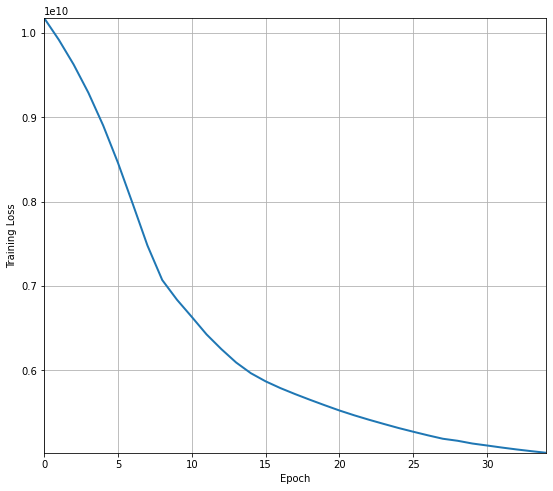

In [51]:
fig_loss = plt.figure()
ax_loss = fig_loss.add_subplot(1, 1, 1)
ax_loss.plot(result.train_losses, linewidth=2, label='Training')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Training Loss')
ax_loss.autoscale(tight=True)
ax_loss.grid();

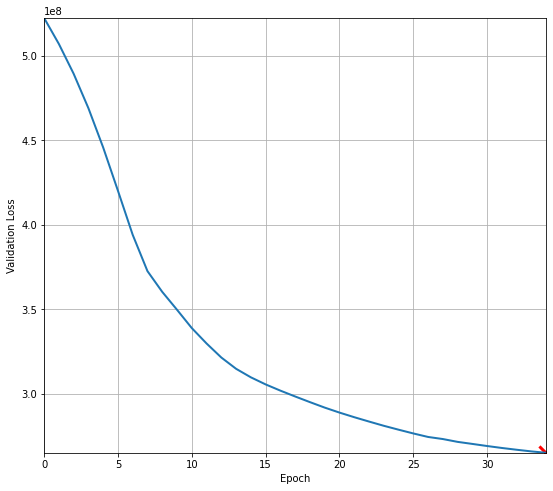

In [52]:
fig_loss = plt.figure()
ax_loss = fig_loss.add_subplot(1, 1, 1)
ax_loss.plot(result.valid_losses, linewidth=2, label='Validation')
ax_loss.scatter(
    (result.best_epoch,), (result.best_valid_loss,),
    linewidth=3, s=200, marker='x', color='red', label='Best')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Validation Loss')
ax_loss.autoscale(tight=True)
ax_loss.grid();

In [53]:
test_words = ['space', 'trump', 'obama', 'apollo', 'the', 'is', 'and', 'cat', 'elliott', ',',   
              'maggie', '.', '99', 'bksdhjfbhyjk', 'america', 'canada', 'omega', 'pytorch']     

test_idxs = th.as_tensor([vocab[word] for word in test_words], dtype=th.int64)                  
test_idxs

tensor([27583, 30281, 20630,  2113, 29437, 15638,  1846,  5232,  9908,    38,
        17920,    44,     2,     1,  1732,  4934, 20863,     1])

In [54]:
print('======= euclidean =======')
nearest_idxs = cbow.nearest(test_idxs).numpy()
for word, idxs in zip(test_words, nearest_idxs):
    print(word)
    print([vocab.reverse[idx] for idx in idxs])
print(nearest_idxs.shape)

======= euclidean =======
space
['space', 'topology', 'utility', 'oscillator', 'discipline', 'controls', 'centers', 'phonology', 'lobby', 'setup']
trump
['trump', 'rockwell', 'clough', 'bloch', 'nixon', 'finley', 'dolan', 'poe', 'parry', 'obama']
obama
['obama', 'trump', 'wordsworth', 'lieutenant', 'poe', 'stanhope', 'gaye', 'cabinet', 'latimer', 'jing']
apollo
['apollo', 'mercury', 'frontline', 'atlas', 'mint', 'babylon', 'hermes', 'liberty', 'invincible', 'nomad']
the
['the', 'america’s', 'its', 'charters', '“the', 'another', 'today’s', 'caicos', 'their', 'manly']
is
['is', 'boasts', 'constitutes', 'contains', 'achieves', 'occupies', 'utilizes', 'makes', 'resembles', 'retains']
and
['and', 'utilizing', 'enabling', 'capturing', 'showing', 'and/or', 'towards', 'while', 'sending', 'sandwiched']
cat
['cat', 'snake', 'nymph', 'sinister', 'dog', 'sweet', 'lark', 'elephant', 'haunting', 'sage']
elliott
['elliott', 'roberts', 'vance', 'jarvis', 'cullen', 'olson', 'emery', 'engel', 'henderson

In [55]:
print('======= cosine =======')
nearest_idxs = cbow.nearest_cosine(test_idxs).numpy()
for word, idxs in zip(test_words, nearest_idxs):
    print(word)
    print([vocab.reverse[idx] for idx in idxs])
print(nearest_idxs.shape)

======= cosine =======
space
['space', 'topology', 'oscillator', 'phonology', 'diversity', 'spaces', 'centers', 'notation', 'geometry', 'propulsion']
trump
['trump', 'clough', 'rockwell', 'nixon', 'finley', 'bloch', 'dolan', 'poe', 'obama', 'lichtenstein']
obama
['obama', 'trump', 'wordsworth', 'lieutenant', 'poe', 'stanhope', 'gaye', 'latimer', 'cabinet', 'jing']
apollo
['apollo', 'babylon', 'invincible', 'hermes', 'mercury', 'voyager', 'argus', 'terminator', 'mirage', 'bleach']
the
['the', 'america’s', 'its', 'today’s', '“the', 'caicos', 'their', 'graders', 'arnhem', 'another']
is
['is', 'boasts', 'constitutes', 'contains', 'achieves', 'occupies', 'utilizes', 'makes', 'resembles', 'retains']
and
['and', 'enabling', 'utilizing', 'sandwiched', 'showing', 'prompting', 'towards', 'sikorsky', '/', 'utilising']
cat
['cat', 'nymph', 'snake', 'haunting', 'comb', 'sinister', 'sauce', 'stalker', 'pet', 'lobster']
elliott
['elliott', 'roberts', 'vance', 'olson', 'cullen', 'emery', 'engel', 'may

tensor(31.5490, grad_fn=<SumBackward0>)

tensor(27.5680, grad_fn=<SumBackward0>)

tensor(30.4884, grad_fn=<SumBackward0>)

In [85]:
(cbow.embedding(th.tensor(vocab['23']))**2).sum()

tensor(32.0000, grad_fn=<SumBackward0>)

In [96]:
emb_mat = cbow.embedding.weight.detach()

In [97]:
emb_mat.shape

torch.Size([32768, 32])

In [98]:
emb_mat[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [99]:
emb_mat[1]

tensor([-0.4857, -0.1680, -0.2881,  1.7850,  0.1005,  0.0575, -0.6526, -0.5757,
         0.5585,  0.9130,  0.9822, -0.2928, -0.4914,  1.4985,  2.0124, -0.5009,
        -0.0243,  0.2896,  0.1180, -1.0195, -0.7109,  1.1856,  0.9750,  0.5419,
        -0.2264, -0.7722, -1.5106,  1.0604,  0.6314, -0.0260,  0.9343, -1.1601])

In [113]:
emb_l2 = th.sqrt((emb_mat**2).sum(1))
emb_l2, math.sqrt(emb_mat.shape[1])

(tensor([0.0000, 4.9247, 5.6569,  ..., 5.6569, 5.6569, 5.6569]),
 5.656854249492381)

In [114]:
emb_l2.min(), emb_l2.max(), emb_l2.mean()

(tensor(0.), tensor(5.6569), tensor(5.5210))

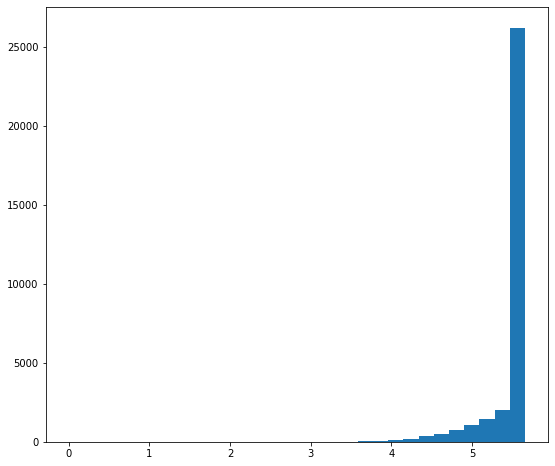

In [120]:
plt.hist(emb_l2.numpy(), bins=30);

In [132]:
means = emb_mat.mean(0)
means.shape

torch.Size([32])

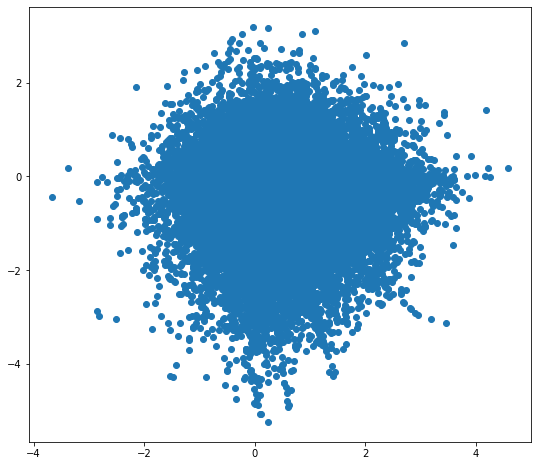

In [153]:
plt.scatter(emb_mat[:, 0], emb_mat[:, 1]);

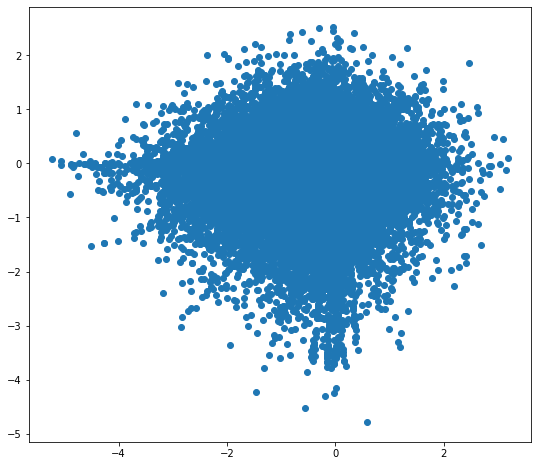

In [154]:
plt.scatter(emb_mat[:, 1], emb_mat[:, 2]);

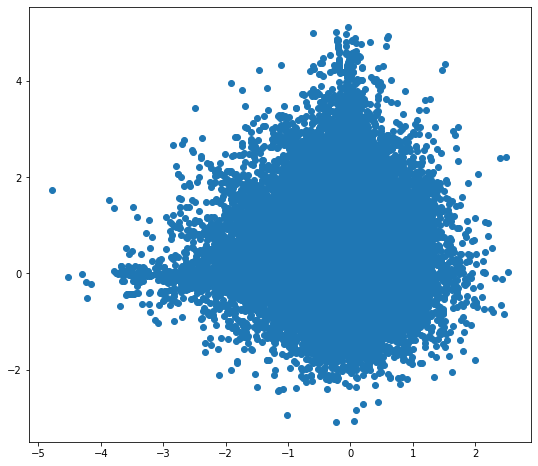

In [155]:
plt.scatter(emb_mat[:, 2], emb_mat[:, 3]);

In [158]:
means = emb_mat.mean(0)
u, d, v = th.svd(emb_mat - means)

mags = d**2 / (emb_mat.shape[0] - 1.0)
w = v.T / d

pcomps = emb_mat @ w

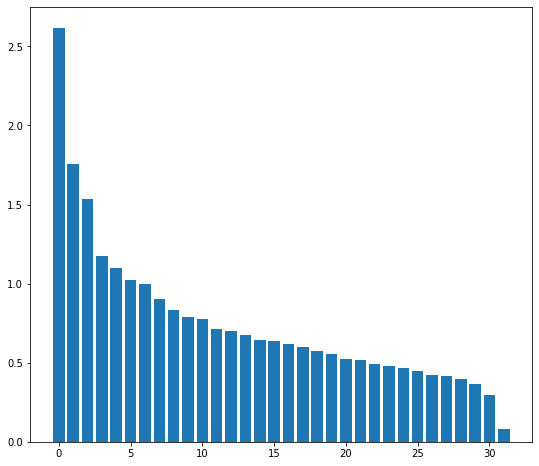

In [165]:
plt.bar(range(mags.shape[0]), mags);

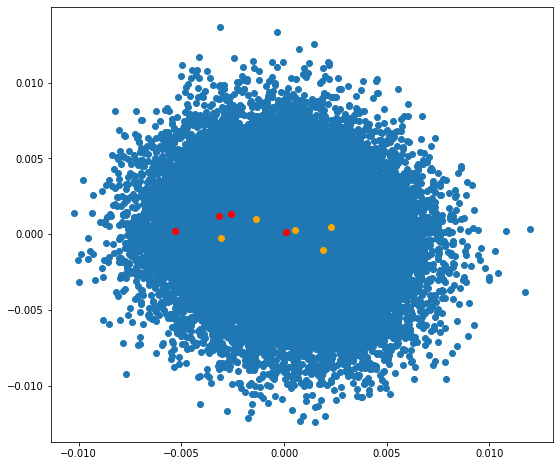

In [161]:
plt.scatter(pcomps[:, 0], pcomps[:, 1]);

words = ('elliott', 'fred', 'frank', 'john')
idxs = [vocab[word] for word in words]
plt.scatter(pcomps[idxs, 0], pcomps[idxs, 1], color='red');


words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [vocab[word] for word in words]
plt.scatter(pcomps[idxs, 0], pcomps[idxs, 1], color='orange');

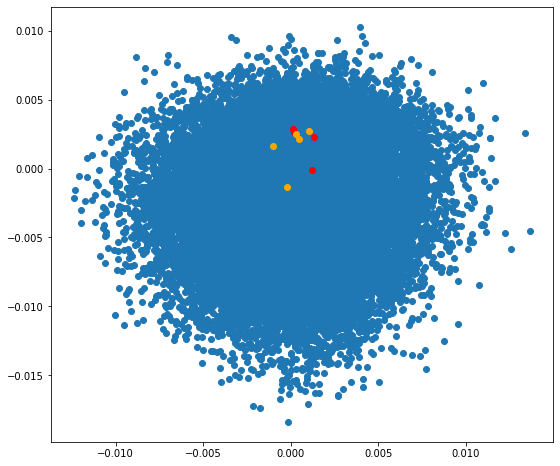

In [162]:
plt.scatter(pcomps[:, 1], pcomps[:, 2]);

words = ('elliott', 'fred', 'frank', 'john')
idxs = [vocab[word] for word in words]
plt.scatter(pcomps[idxs, 1], pcomps[idxs, 2], color='red');


words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [vocab[word] for word in words]
plt.scatter(pcomps[idxs, 1], pcomps[idxs, 2], color='orange');

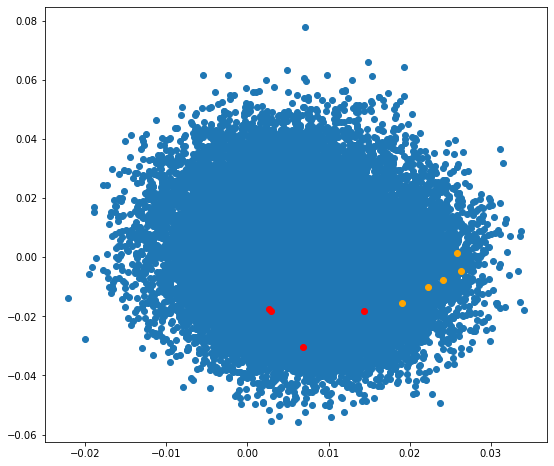

In [163]:
plt.scatter(pcomps[:, 30], pcomps[:, 31]);

words = ('elliott', 'fred', 'frank', 'john')
idxs = [vocab[word] for word in words]
plt.scatter(pcomps[idxs, 30], pcomps[idxs, 31], color='red');


words = ('omega', 'mu', 'alpha', 'beta', 'gamma')
idxs = [vocab[word] for word in words]
plt.scatter(pcomps[idxs, 30], pcomps[idxs, 31], color='orange');